<a href="https://colab.research.google.com/github/jamiehadd/Math189AD-MathematicalDataScienceAndTopicModeling/blob/main/NMF_for_Dimensionality_Reduction_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Math 189: NMF, Dimensionality Reduction, and Clustering

In this live script, we'll explore the output of NMF and other dimensionality reduction and clustering models on a toy dataset.  

The dataset we'll explore is the Swimmer dataset, which was built by Donoho and Stodden for their NeurIPS 2004 paper [When does nonnegative matrix factorization give a correct decomposition into parts?](https://proceedings.neurips.cc/paper/2003/file/1843e35d41ccf6e63273495ba42df3c1-Paper.pdf)  This is a synthetic image dataset where the data points are images of a stick-figure model of a swimmer with four limbs that occur in various positions.

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
from google.colab import files                        #REPLACE WHEN FILE LOADING IS FIGURED OUT
uploaded = files.upload()

Saving Swimmer.mat to Swimmer.mat


First, we'll open the dataset and explore some of the images!  It is important to always investigate your dataset before applying data scientific models.  Having a thorough understanding of your data is necessary before you'll be able to interpret output from the model!

In [4]:
mat = scipy.io.loadmat("Swimmer.mat")                 #load the dataset
X = mat['X']                                          #in this .mat file, the data is called X
numPixels, numPics = X.shape                          #record the number of images in the dataset, and number of pixels in each image

pic17 = np.reshape(X[:,17],(11,20));                  #grab the 17th image and reshape into image format
pic170 = np.reshape(X[:,170],(11,20));                #grab the 170th image and reshape into image format

([], <a list of 0 Text major ticklabel objects>)

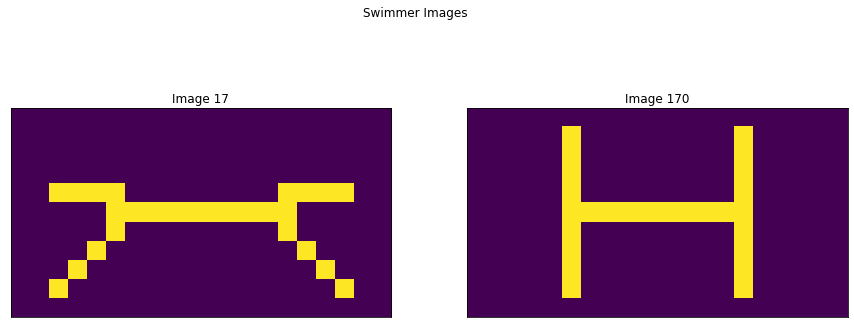

In [8]:
plt.figure(figsize=[15,6])

plt.suptitle("Swimmer Images")
plt.subplot(1,2,1);
plt.imshow(pic17)                                     #display images
plt.title("Image 17")
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2);
plt.imshow(pic170)
plt.title("Image 170")
plt.xticks([])
plt.yticks([])

###Nonnegative Matrix Factorization

Now we'll apply NMF models to this dataset and investigate the results!

**A sidebar:** one thing folks often ask about when seeing NMF on images for the first time is whether we can just apply NMF directly to a single image (viewing it as a matrix) to learn the parts of the image.  This is possible, but the W and H matrices will have completely different interpretations (pixel intensities shared simultaneously in both horizontal and vertical regions of the image).  Here's an example on the 17th image from Swimmer.

In [9]:
model = NMF(n_components=3, init='random', random_state=0,max_iter = 1000)  #learn the NMF model
W = model.fit_transform(pic17)                                              #access the NMF factor matrices
H = model.components_

Now, we'll visualize the original image, the factor matrices $W$ and $H$, and the approximation to the image, $W*H$.  How can you interpret $W$?  And $H$? 

([], <a list of 0 Text major ticklabel objects>)

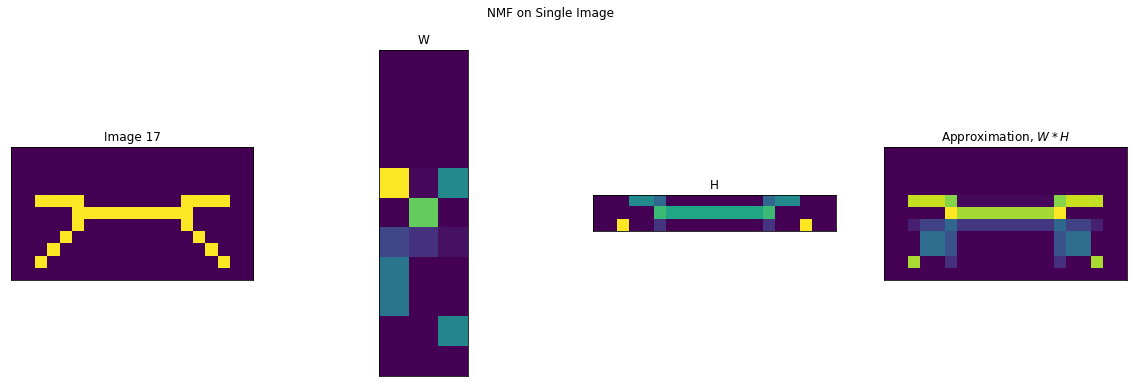

In [11]:
plt.figure(figsize=[20,6])

plt.suptitle("NMF on Single Image")
plt.subplot(1,4,1);
plt.imshow(pic17);
plt.title("Image 17")
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,2);
plt.imshow(W);
plt.title("W")
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,3);
plt.imshow(H);
plt.title("H")
plt.xticks([])
plt.yticks([])

plt.subplot(1,4,4);
plt.imshow(W@H);
plt.title("Approximation, $W*H$")
plt.xticks([])
plt.yticks([])

We can investigate the "parts" detected by forming the rank one matrices defined in $W*H$.

([], <a list of 0 Text major ticklabel objects>)

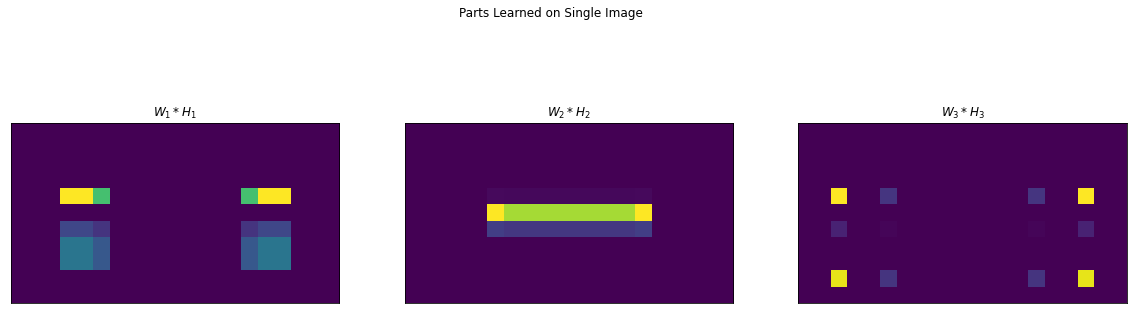

In [13]:
plt.figure(figsize=[20,6])

plt.suptitle("Parts Learned on Single Image")
plt.subplot(1,3,1);
plt.imshow(np.outer(W[:,0],H[0,:]));
plt.title("$W_1*H_1$")
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2);
plt.imshow(np.outer(W[:,1],H[1,:]));
plt.title("$W_2*H_2$")
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3);
plt.imshow(np.outer(W[:,2],H[2,:]));
plt.title("$W_3*H_3$")
plt.xticks([])
plt.yticks([])

The structure of the NMF model is such that an approximation to an unvectorized image must consist of rank one matrices (which have rectangular regions of constant intensity).  Natural images (e.g., with areas of constant consistency that are "curvy") are not well-served by this model!

Now let's try applying NMF to the vectorized images with varying model rank, k, and take a look at the error.

In [14]:
nmf_errs = []

for k in range(20):
  model = NMF(n_components=k+1, init='random', random_state=0, max_iter = 1000) #learn the NMF model with rank k+1
  W = model.fit_transform(X)                                                    #access the NMF factor matrices
  H = model.components_

  nmf_errs.append(np.linalg.norm(X-W@H)**2)                                     #record model error

  if k == 9:                                                                    #save the model info for a couple specific values of k
    W10 = W
    H10 = H

  if k == 16:
    W17 = W
    H17 = H

Text(0, 0.5, 'model error, $\\|X - WH\\|_F^2$')

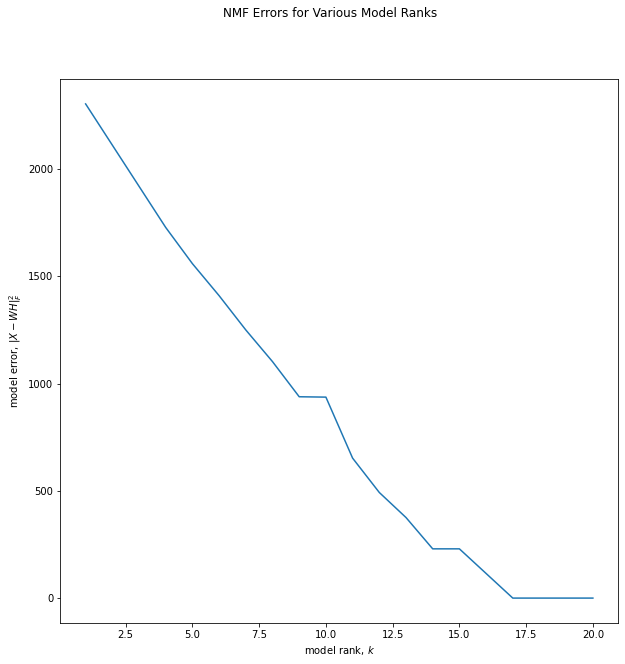

In [16]:
plt.figure(figsize=[10,10])

plt.suptitle("NMF Errors for Various Model Ranks")
plt.plot(range(1,21),nmf_errs)                                                  #plot the error
plt.xlabel("model rank, $k$")
plt.ylabel("model error, $\|X - WH\|_F^2$")

We see that (at least most of the time) NMF is able to achieve zero error for model rank 17 and above!  This has to do with the structure of the data -- the four limbs each can be in one of four positions. Actually, this dataset should be able to achieve zero error for rank 16, but this doesn't often happen due to the choice of objective (Fro-norm) and the algorithm used (Lee and Seung's multiplicative updates).

Let's view the basis images for the swimmer data set!  First, let's consider the basis images for the NMF model with rank 17.

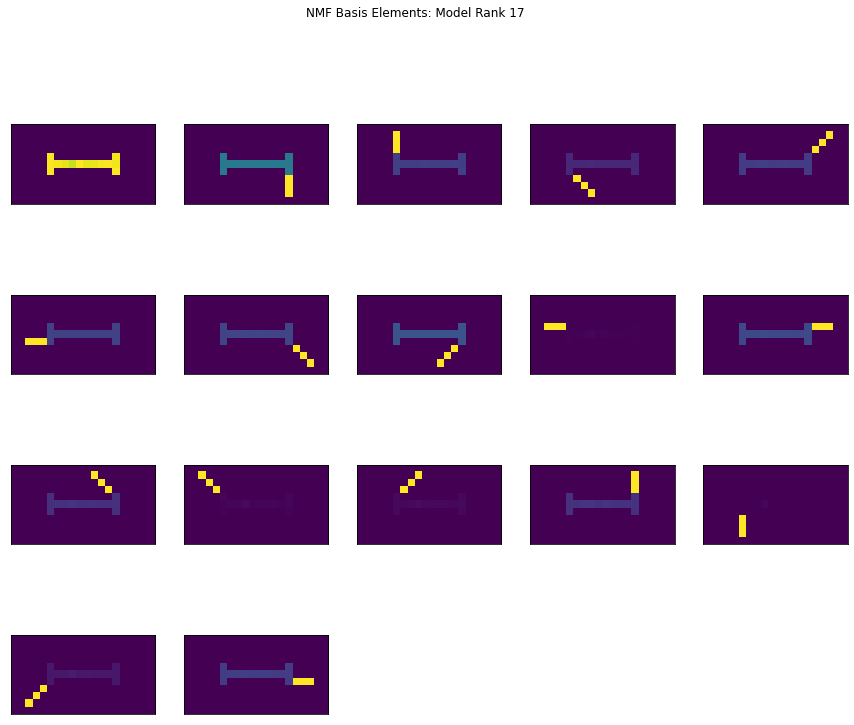

In [17]:
plt.figure(figsize=[15,12])

plt.suptitle("NMF Basis Elements: Model Rank 17")
for i in range(17):
  plt.subplot(4,5,i+1)
  plt.imshow(np.reshape(W17[:,i],(11,20)))
  plt.xticks([])
  plt.yticks([])

And now the basis images for the NMF model with rank 10!

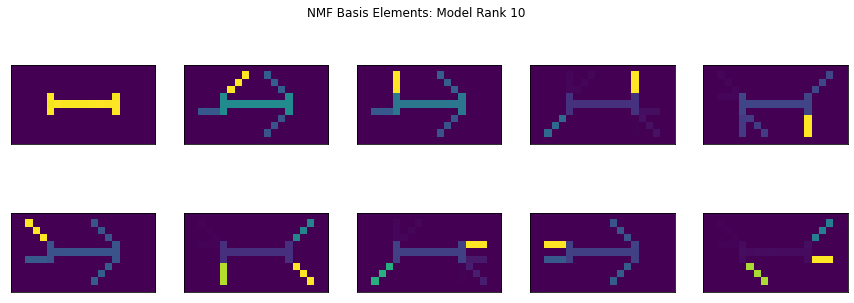

In [21]:
plt.figure(figsize=[15,5])

plt.suptitle("NMF Basis Elements: Model Rank 10")
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(np.reshape(W10[:,i],(11,20)))
  plt.xticks([])
  plt.yticks([])

###Dimensionality Reduction

This model has produced a lower-dimensional representation of the data.  Remember that the original data was 220-dimensional (vectorized pixels) and now each point is represented by the ten-dimensional vector of coefficients. 

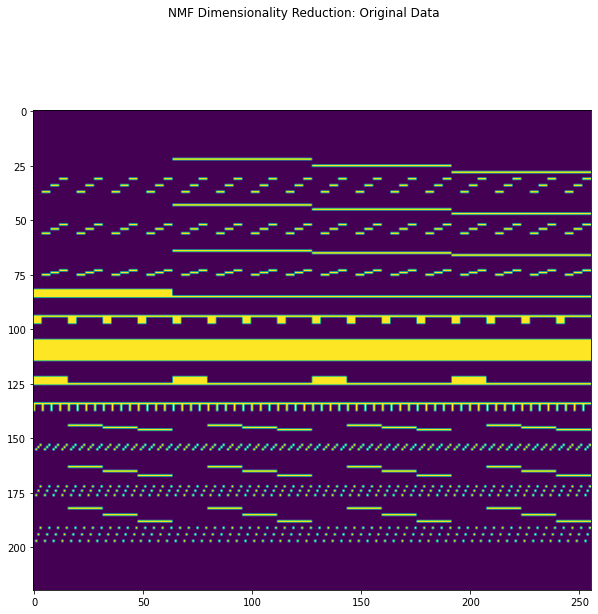

In [22]:
plt.figure(figsize=[10,10])

plt.suptitle("NMF Dimensionality Reduction: Original Data")
plt.imshow(X)

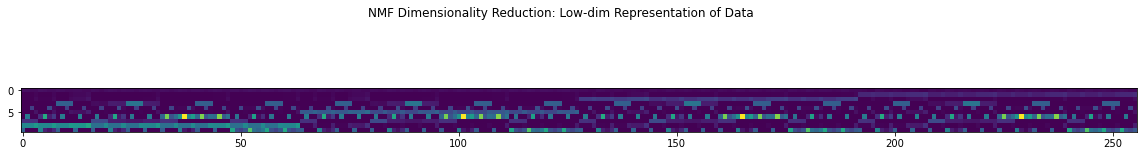

In [25]:
plt.figure(figsize=[20,3])

plt.suptitle("NMF Dimensionality Reduction: Low-dim Representation of Data")
plt.imshow(H10)

The most popular model for dimensionality reduction is probably principal component analysis (PCA).  Let's see what PCA gives us on this dataset!  We'll visualize the first 10 principal components.

In [26]:
pca = PCA(n_components=10)
X_new = pca.fit_transform(X.transpose())

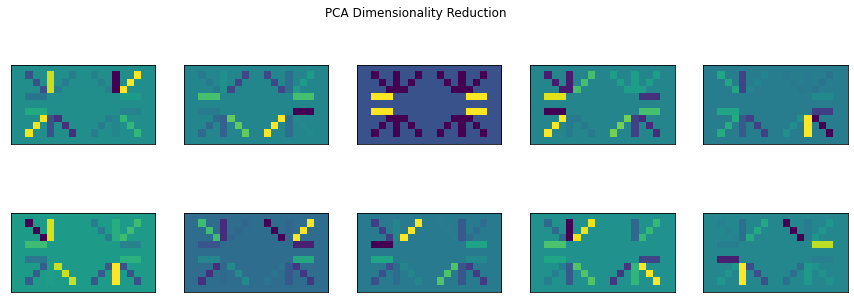

In [28]:
plt.figure(figsize=[15,5])

plt.suptitle("PCA Dimensionality Reduction")
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(np.reshape(pca.components_[i],(11,20)))
  plt.xticks([])
  plt.yticks([])

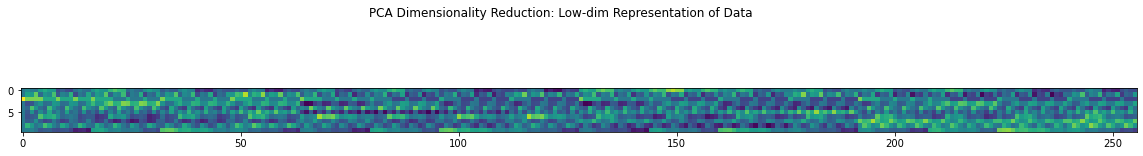

In [29]:
plt.figure(figsize=[20,3])

plt.suptitle("PCA Dimensionality Reduction: Low-dim Representation of Data")
plt.imshow(X_new.transpose())

###Clustering

The NMF model can also be used for clustering information.  One of the most common (and somewhat natural) way to do this is to transform the columns of the H matrix into one-hot vectors.  Whichever entry is transformed to one indicates which cluster the data point is associated with it.  Let's try this on the rank 10 model data!

In [30]:
NMF_cluster = H10
for j in range(np.shape(H10)[1]):
  NMF_cluster[:,j] = (NMF_cluster[:,j] == np.max(NMF_cluster[:,j]))

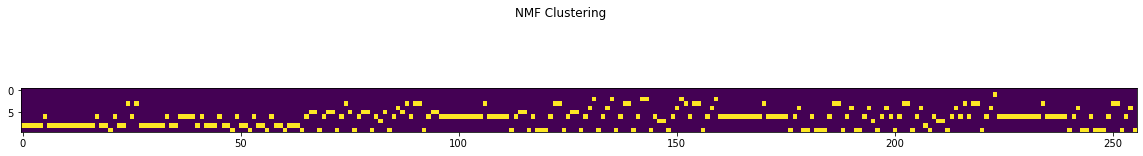

In [31]:
plt.figure(figsize=[20,3])

plt.suptitle("NMF Clustering")
plt.imshow(NMF_cluster)

In [32]:
np.sum(NMF_cluster,1)                                                           #number of elements in each of the 10 clusters

array([ 0.,  1.,  6., 25., 14., 15., 97.,  6., 44., 48.])

Let's also see the average element in each cluster!

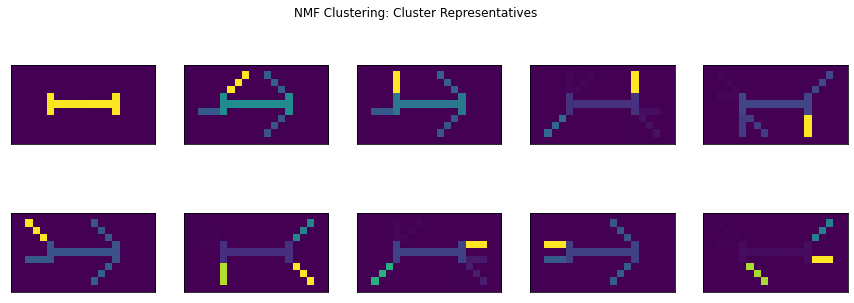

In [34]:
plt.figure(figsize=[15,5])

plt.suptitle("NMF Clustering: Cluster Representatives")

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(np.reshape(W10[:,i],(11,20)))
  plt.xticks([])
  plt.yticks([])

The most popular model for clustering is probably k-means.  Let's see what this model gives us on this data!  We'll visualize the cluster centers learned by the model.

In [35]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X.transpose())

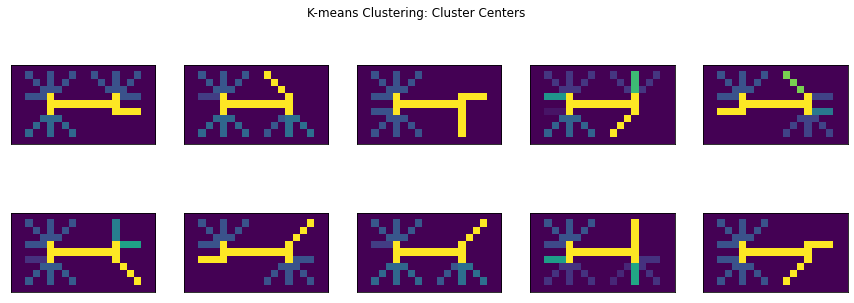

In [36]:
plt.figure(figsize=[15,5])

plt.suptitle("K-means Clustering: Cluster Centers")

for cluster in range(10):
  plt.subplot(2,5,cluster+1)
  plt.imshow(np.reshape(kmeans.cluster_centers_[cluster],(11,20)))
  plt.xticks([])
  plt.yticks([])

##Activity

We'll now explore these models and applications on a new data set!  You may work with either the dataset you selected last week or you may select a new dataset.  It does not need to be an image dataset but you should try to select a dataset where you believe the outputs from these models will be interpretable and visualizable!
You do not need to work in Matlab -- if you prefer Python or R, all of the methods I've used above are available in packages in these languages, you just will need to do some Googling!

###Tasks 

*   Select a dataset and investigate it -- what are the elements and entries?  Try visualizing the data in various formats (e.g., heatmaps, histograms/counts of values, visualizing individual elements, etc.).
*   Apply NMF with various model ranks to your data.  Think about the interpretation of the two factor matrices!
*   Think about NMF as both a dimensionality reduction and clustering model.
*   Compare NMF to PCA for dimensionality reduction and to k-Means for clustering!
*   Create some summative visualizations of the results -- think about what visualizations best serve what you have observed/want to show about the results!